In [1]:
from itertools import zip_longest
from matplotlib.pyplot import figure
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from scipy.sparse import csr_array
from scipy.sparse import find
from pickleshare import PickleShareDB

df = pd.read_csv('../input/abcnews-date-text.csv')
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#tokenize and sanitize

#tokenize documents into individual words
df['tokenized'] = df.headline_text.str.split(' ')

#remove short documents from corpus
df['length'] = df.tokenized.map(len)
df = df.loc[df.length > 1]

#use random subset of corpus
df=df.sample(frac=0.0016).reset_index()

#flatten all words into single series
ex = df.explode('tokenized')

#remove shorter words
ex = ex.loc[ex.tokenized.str.len() > 2]

#remove stopwords
ex = ex.loc[~ex.tokenized.isin(stopwords_set)]

In [3]:
#ceate dictionary of words

#shuffle for sparse matrix visual
dictionary = ex.tokenized.drop_duplicates().sample(frac=1)

#dataframe with (index/code):word
dictionary = pd.Series(dictionary.tolist(), name='words').to_frame()

#store code:word dictionary for reverse encoding
dictionary_lookup = dictionary.to_dict()['words']

#offset index to prevent clash with zero fill
dictionary['encode'] = dictionary.index + 1

#store word:code dictionary for encoding
dictionary = dictionary.set_index('words').to_dict()['encode']


In [4]:
#reduced grouping from group by dataframe to to group by series and aggregated to tuple
#improved from 30s to 20s with whole dataset

#use dictionary to encode each word to integer representation
encode = ex.tokenized.map(dictionary.get).to_frame()
encode.index.astype('int')
encode.tokenized.astype('int')
#un-flatten encoded words back into original documents
encoded_docs  = encode.tokenized.groupby(level=0).agg(tuple)

#match up document indexes for reverse lookup
docs = df.sort_index().iloc[encoded_docs.index].reset_index()
encoded_docs  = encoded_docs .reset_index()['tokenized']


In [5]:

#zero pad x dimension by longest sentence
encoded_docs = list(zip(*zip_longest(*encoded_docs.to_list(), fillvalue=0)))

#convert to sparse matrix
encoded_docs = csr_array(encoded_docs, dtype=int)

#convert to index for each word
row_column_code = find(encoded_docs)

#presort by words
word_sorted_index = row_column_code[2].argsort()
doc_word = np.array([row_column_code[0][word_sorted_index], row_column_code[2][word_sorted_index]])

#presort by docs and words
doc_word_sorted_index = doc_word[0].argsort()


tfidf = pd.DataFrame(np.array([doc_word[0][doc_word_sorted_index], doc_word[1][doc_word_sorted_index]]).T, columns=['doc','word'])

#offset code no longer needed after zerofill
tfidf.word = tfidf.word - 1


In [6]:
#Term Frequency
#(num_term_in_doc)/(num_words_in_doc)
#Inverse Document Frequency
#log(num_documents/num_docs_with_term)
#Term Frequency Inverse Document Frequency
#(num_term_in_doc)/(num_words_in_doc) * log(num_documents/num_docs_with_term)

tfidf = tfidf.groupby(['doc','word']).size().to_frame('num_term_in_doc').reset_index()

tfidf['num_words_in_doc'] = tfidf.groupby('doc')['num_term_in_doc'].transform('sum')

tfidf['num_documents'] = tfidf.doc.nunique()

tfidf['num_docs_with_term'] = tfidf.groupby('word')['doc'].transform('count')

tfidf['tf'] = tfidf.num_term_in_doc/tfidf.num_words_in_doc

tfidf['idf'] = np.log(tfidf.num_documents/tfidf.num_docs_with_term)

tfidf['tfidf'] = tfidf.tf * tfidf.idf

doc_lookup = tfidf[['doc','word','tfidf']]

tfidf = tfidf.to_numpy().T

doc_lookup.head(10)

,doc,word,tfidf
0,0,170,1.150373
1,0,308,1.265898
2,0,460,1.150373
3,0,3507,1.265898
4,0,3792,1.265898
5,0,4937,1.082796
6,1,697,0.967271
7,1,1335,0.919324
8,1,1606,1.265898
9,1,1694,0.838406


Stored 'sparse_tfidf_matrix' (csc_array)
Stored 'dictionary' (dict)
Stored 'dictionary_lookup' (dict)
Stored 'doc_lookup' (DataFrame)
Stored 'docs' (DataFrame)


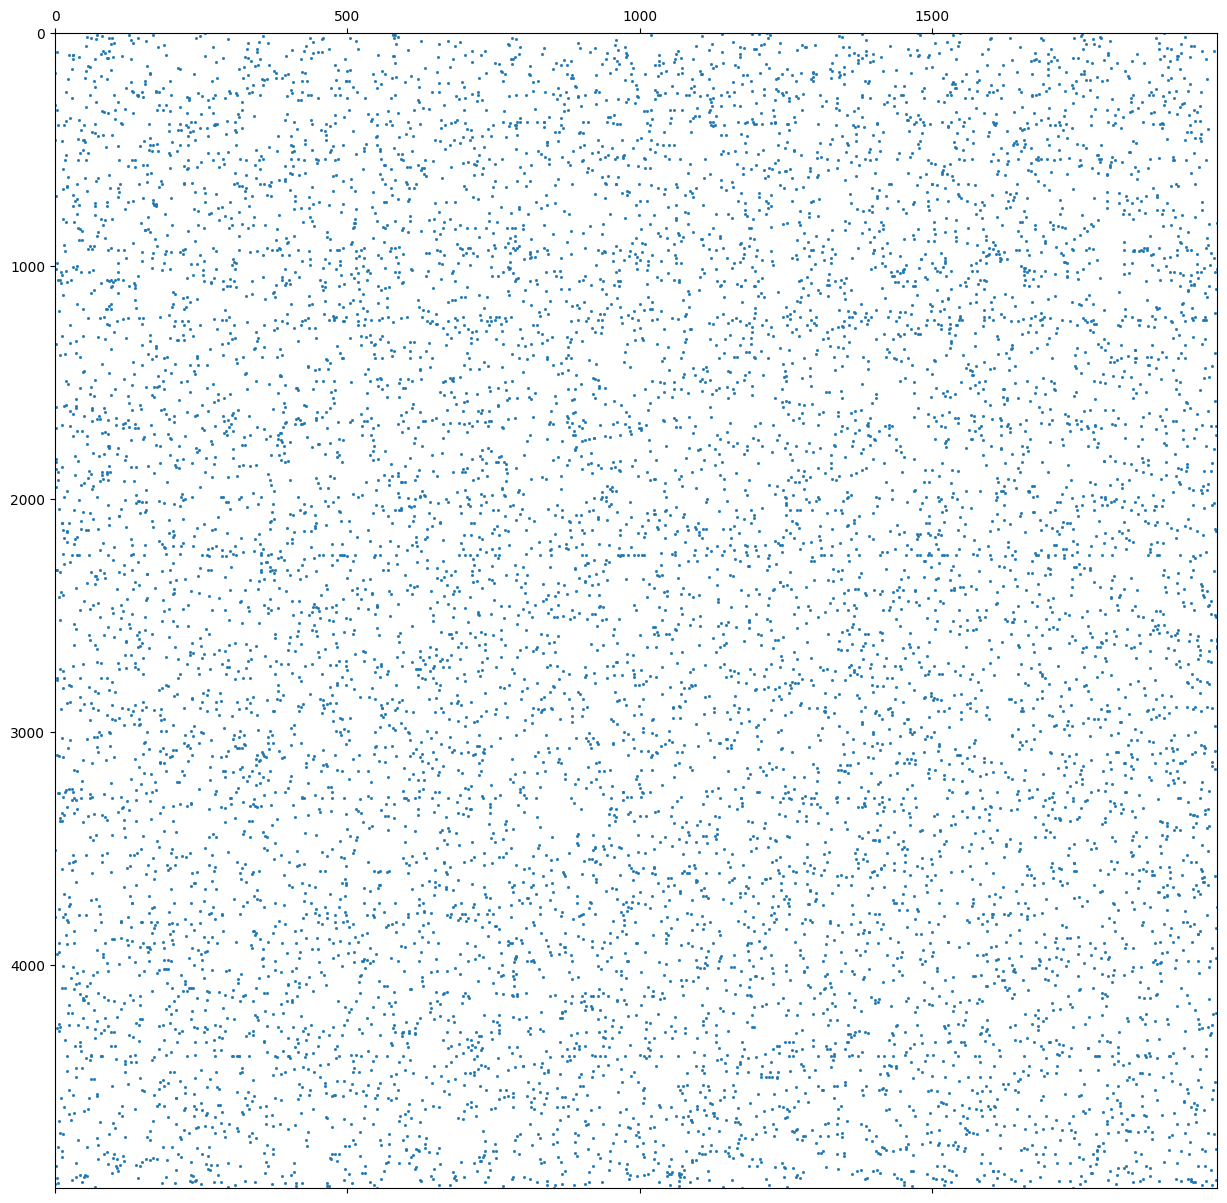

In [7]:
sparse_tfidf_matrix = csr_array((tfidf[2],(tfidf[0],tfidf[1])), shape=(np.size(encoded_docs, 0),len(dictionary)), dtype=float).T

#visualize sparse matrix
fig = figure(figsize=(15,15))
sparse_tfidf_matrix_visualization = fig.add_subplot(1,1,1)
sparse_tfidf_matrix_visualization.spy(sparse_tfidf_matrix, markersize=1, aspect = 'auto')

%store sparse_tfidf_matrix
%store dictionary
%store dictionary_lookup
%store doc_lookup
%store docs